In [10]:
import pandas as pd

# 读取数据集
df = pd.read_excel('AURN ST PAULS AIR.xlsx')
df = df.dropna()

# 转换日期时间格式
df['Date Time'] = pd.to_datetime(df['Date Time'])

# 检查并处理异常值
columns = ['NOx', 'NO2', 'NO', 'PM10', 'PM2.5', 'O3', 'Temperature']
for col in columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]




# 对连续变量进行标准化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['NOx', 'NO2', 'NO', 'PM10', 'PM2.5', 'O3', 'Temperature']] = scaler.fit_transform(df[['NOx', 'NO2', 'NO', 'PM10', 'PM2.5', 'O3', 'Temperature']])

# 计算相关性矩阵
corr_matrix = df[['NOx', 'NO2', 'NO', 'PM10', 'PM2.5', 'O3', 'Temperature']].corr()
print(corr_matrix)


                  NOx       NO2        NO      PM10     PM2.5        O3  \
NOx          1.000000  0.979872  0.579907  0.130034  0.237307 -0.483911   
NO2          0.979872  1.000000  0.405616  0.135931  0.256689 -0.497089   
NO           0.579907  0.405616  1.000000  0.040475  0.038832 -0.187220   
PM10         0.130034  0.135931  0.040475  1.000000  0.573458  0.093637   
PM2.5        0.237307  0.256689  0.038832  0.573458  1.000000 -0.017862   
O3          -0.483911 -0.497089 -0.187220  0.093637 -0.017862  1.000000   
Temperature -0.250864 -0.282937  0.005605  0.044450 -0.076048  0.142399   

             Temperature  
NOx            -0.250864  
NO2            -0.282937  
NO              0.005605  
PM10            0.044450  
PM2.5          -0.076048  
O3              0.142399  
Temperature     1.000000  


In [49]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import explained_variance_score

# 读取数据集
df = pd.read_excel('AURN ST PAULS AIR.xlsx')

# 删除带有缺失值的行
df.dropna(inplace=True)

# 转换时间格式
df['Date Time'] = pd.to_datetime(df['Date Time'])

# 异常检测
#quantiles = df[['NOx', 'NO2', 'NO', 'PM10', 'PM2.5', 'O3', 'Temperature']].quantile([0.25, 0.75])
#for col in ['NOx', 'NO2', 'NO', 'PM10', 'PM2.5', 'O3', 'Temperature']:
#    q1 = quantiles.loc[0.25, col]
#    q3 = quantiles.loc[0.75, col]
#    iqr = q3 - q1
#    upper = q3 + 1.5 * iqr
#    lower = q1 - 1.5 * iqr
 #   df = df[(df[col] >= lower) & (df[col] <= upper)]

# 数据标准化
continuous_cols = ['NOx', 'NO2', 'NO', 'PM10', 'PM2.5', 'O3', 'Temperature']
scaler = StandardScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

# 构建时间序列特征
df['hour'] = df['Date Time'].dt.hour
df['day_of_week'] = df['Date Time'].dt.dayofweek
df['day_of_month'] = df['Date Time'].dt.day
df['month'] = df['Date Time'].dt.month
df['year'] = df['Date Time'].dt.year
print(df.head())
print(df.dtypes)

# 将数据集分成两份
train_df = df[df['Date Time'] < '2020-01-01']
test_df = df[(df['Date Time'] >= '2020-03-10') & (df['Date Time'] <= '2020-05-10')]

# 打印训练集和测试集的大小
print("Training set size: ", len(train_df))
print("Test set size: ", len(test_df))



                   Date Time       NOx       NO2        NO      PM10  \
22 2021-01-08 19:00:00+00:00  0.668894  1.263068  0.369158  1.075305   
23 2021-01-09 13:00:00+00:00 -0.187906 -0.177529 -0.169265 -0.278272   
24 2021-01-10 04:00:00+00:00  0.427632  1.067795  0.139772  1.345964   
25 2021-01-10 21:00:00+00:00 -0.134160  0.190214 -0.238034 -0.368491   
27 2021-01-12 03:00:00+00:00 -0.512589 -0.982107 -0.277672 -1.270876   

       PM2.5        O3  Temperature  hour  day_of_week  day_of_month  month  \
22  2.181304 -1.845730    -2.327608    19            4             8      1   
23 -0.200153 -0.814275    -1.313151    13            5             9      1   
24  2.067902 -1.894200    -2.404171     4            6            10      1   
25  0.026652 -0.354775    -1.217448    21            6            10      1   
27 -0.880570  0.938422    -0.088147     3            1            12      1   

    year  
22  2021  
23  2021  
24  2021  
25  2021  
27  2021  
Date Time       datetime64

In [30]:
# 按照需求划分数据集
X = df[['hour', 'day_of_week', 'day_of_month', 'month', 'year', 'Temperature', 'PM2.5', 'PM10', 'O3',"NO","NO2"]]
y = df["NOx"]
X_train=train_df[['hour', 'day_of_week', 'day_of_month', 'month', 'year', 'Temperature', 'PM2.5', 'PM10', 'O3',"NO","NO2"]]
X_test = test_df[['hour', 'day_of_week', 'day_of_month', 'month', 'year', 'Temperature', 'PM2.5', 'PM10', 'O3',"NO","NO2"]]
y_train = train_df["NOx"]
y_test = test_df["NOx"]


# 使用BRT进行预测
model = GradientBoostingRegressor(n_estimators=1000, max_depth=9, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [31]:
# 评估模型性能
f2 = sum((y_pred / y_test >= 0.5) & (y_pred / y_test <= 2)) / len(y_test)
coe = explained_variance_score(y_test, y_pred)
ioa = 1 - sum((y_test - y_pred)**2) / sum((np.abs(y_pred - y_test.mean()) + np.abs(y_test - y_test.mean()))**2)
r2 = model.score(X_test, y_test)

# 输出交叉验证的衡量指标
print('Factor-of-two (F2): %.3f' % f2)
print('Coefficient of Efficiency (COE): %.3f' % coe)
print('Index of Agreement (IOA): %.3f' % ioa)
print('R-squared (R2): %.3f' % r2)

# 输出模型性能指标
print('Mean Squared Error (MSE): %.3f' % mean_squared_error(y_test, y_pred))
print('Mean Absolute Error (MAE): %.3f' % mean_absolute_error(y_test, y_pred))


Factor-of-two (F2): 0.998
Coefficient of Efficiency (COE): 1.000
Index of Agreement (IOA): 1.000
R-squared (R2): 1.000
Mean Squared Error (MSE): 0.000
Mean Absolute Error (MAE): 0.002


C:\Users\Cathy\AppData\Local\Temp\ipykernel_32968\1790993242.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['NOx_pred'] = y_pred


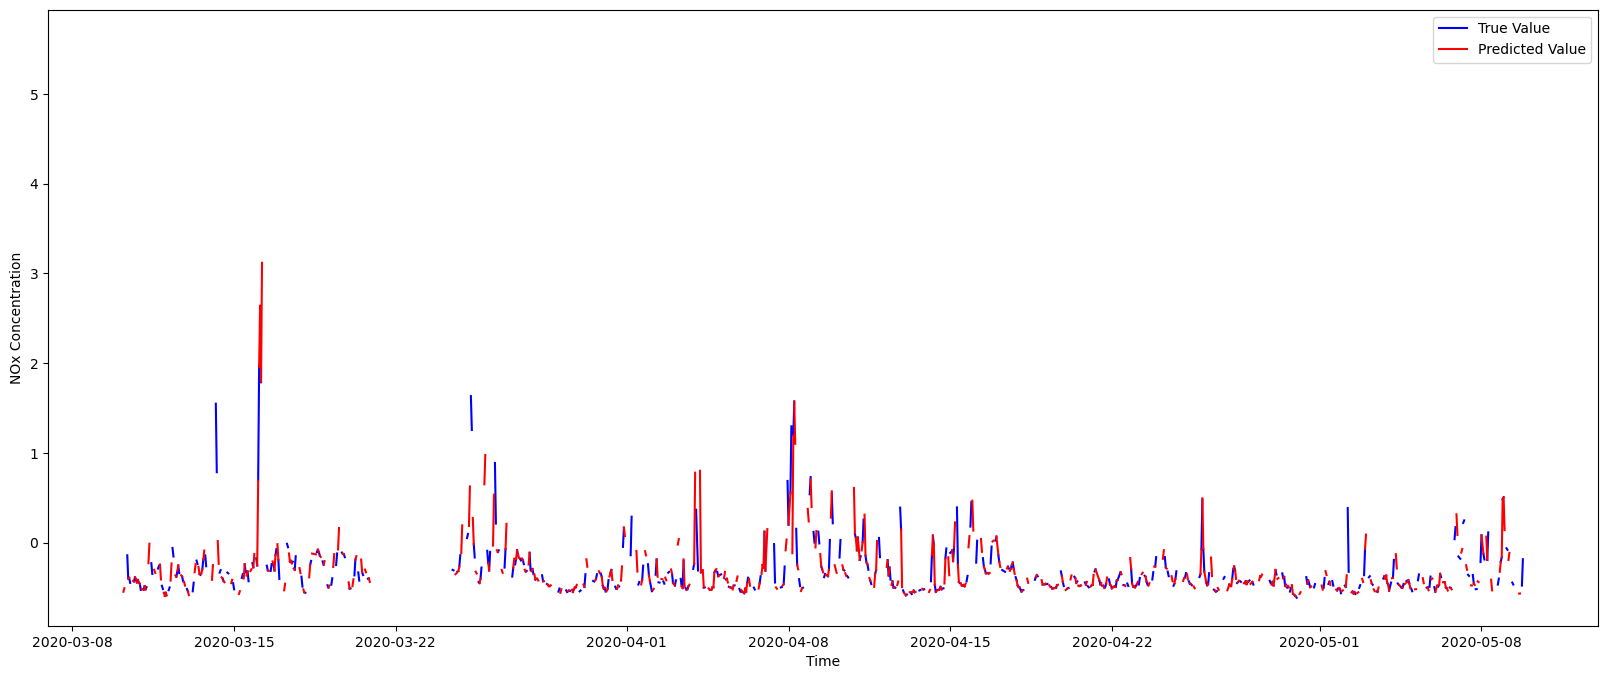

In [32]:
test_df['NOx_pred'] = y_pred
result_df = pd.concat([test_df[['Date Time', 'NOx']], test_df[['Date Time', 'NOx_pred']]], axis=0)
result_df.sort_values('Date Time', inplace=True)
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(result_df['Date Time'], result_df['NOx'], color='blue', label='True Value')
plt.plot(result_df['Date Time'], result_df['NOx_pred'], color='red', label='Predicted Value')
plt.xlabel('Time')
plt.ylabel('NOx Concentration')
plt.legend()
plt.show()


In [26]:
# 按照需求划分数据集
X = df[['hour', 'day_of_week', 'day_of_month', 'month', 'year', 'Temperature']]
y = df["NOx"]
X_train=train_df[['hour', 'day_of_week', 'day_of_month', 'month', 'year', 'Temperature']]
X_test = test_df[['hour', 'day_of_week', 'day_of_month', 'month', 'year', 'Temperature']]
y_train = train_df["NOx"]
y_test = test_df["NOx"]


# 使用BRT进行预测
model = GradientBoostingRegressor(n_estimators=1000, max_depth=9, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [28]:
# 评估模型性能
f2 = sum((y_pred / y_test >= 0.5) & (y_pred / y_test <= 2)) / len(y_test)
coe = explained_variance_score(y_test, y_pred)
ioa = 1 - sum((y_test - y_pred)**2) / sum((np.abs(y_pred - y_test.mean()) + np.abs(y_test - y_test.mean()))**2)
r2 = model.score(X_test, y_test)

# 输出交叉验证的衡量指标
print('Factor-of-two (F2): %.3f' % f2)
print('Coefficient of Efficiency (COE): %.3f' % coe)
print('Index of Agreement (IOA): %.3f' % ioa)
print('R-squared (R2): %.3f' % r2)

# 输出模型性能指标
print('Mean Squared Error (MSE): %.3f' % mean_squared_error(y_test, y_pred))
print('Mean Absolute Error (MAE): %.3f' % mean_absolute_error(y_test, y_pred))


Factor-of-two (F2): 0.454
Coefficient of Efficiency (COE): -0.954
Index of Agreement (IOA): 0.438
R-squared (R2): -1.287
Mean Squared Error (MSE): 0.345
Mean Absolute Error (MAE): 0.362


C:\Users\Cathy\AppData\Local\Temp\ipykernel_32968\1790993242.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['NOx_pred'] = y_pred


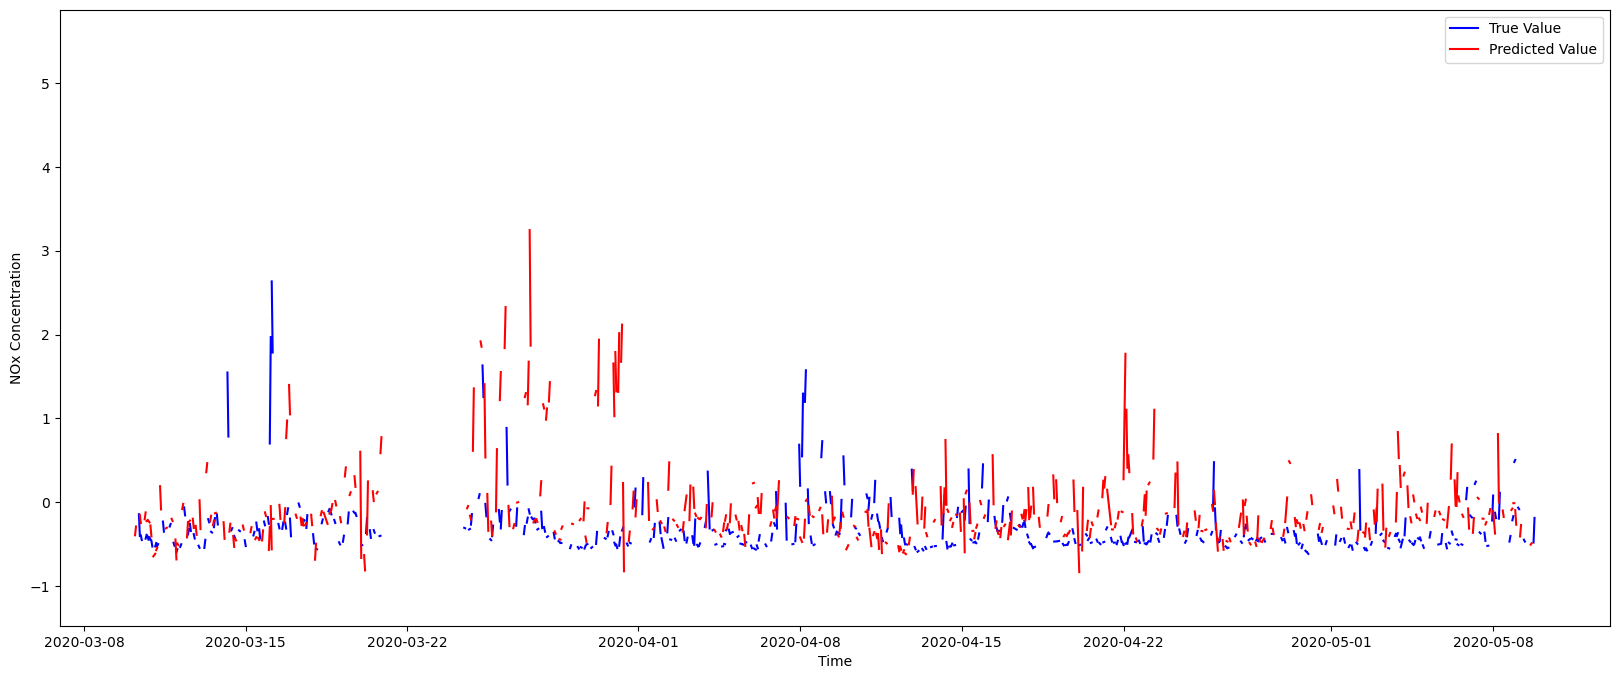

In [29]:
test_df['NOx_pred'] = y_pred
result_df = pd.concat([test_df[['Date Time', 'NOx']], test_df[['Date Time', 'NOx_pred']]], axis=0)
result_df.sort_values('Date Time', inplace=True)
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(result_df['Date Time'], result_df['NOx'], color='blue', label='True Value')
plt.plot(result_df['Date Time'], result_df['NOx_pred'], color='red', label='Predicted Value')
plt.xlabel('Time')
plt.ylabel('NOx Concentration')
plt.legend()
plt.show()


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import explained_variance_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime
# 读取数据集

df = pd.read_excel("BOND ST EB L3 TRAFFIC.xlsx")


# 转换日期时间格式
df['Date Time'] = pd.to_datetime(df['Date Time'])
df.sort_values('Date Time', inplace=True)

# 检查并处理异常值
q1 = df['Hourly Flow'].quantile(0.25)
q3 = df['Hourly Flow'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr
df = df[(df['Hourly Flow'] >= lower) & (df['Hourly Flow'] <= upper)]

df['Hourly Flow'].interpolate(inplace=True)
df.dropna(inplace=True)

# 标准化数据
#for col in ['Hourly Flow', 'Hourly Profile']:
   # mean = df[col].mean()
   # std = df[col].std()
   # df[col] = (df[col] - mean) / std

# 去除重复时间戳
df = df[~df.index.duplicated(keep='first')]

# 设置索引并重新生成时间序列
df = df.set_index("Date Time")
df = df.reindex(pd.date_range(start=df.index[0], end=df.index[-1], freq='H'))

# 标准化数据
#for col in ['Hourly Flow', 'Hourly Profile']:
   # mean = df[col].mean()
   # std = df[col].std()
   # df[col] = (df[col] - mean) / std





In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [49]:
print(df.head())

                     Hourly Flow  Hourly Profile
2020-01-01 00:00:00        304.0           144.0
2020-01-01 01:00:00        344.0            96.0
2020-01-01 02:00:00        344.0            88.0
2020-01-01 03:00:00        320.0            56.0
2020-01-01 04:00:00        320.0            24.0


D:\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


<Figure size 1200x500 with 0 Axes>

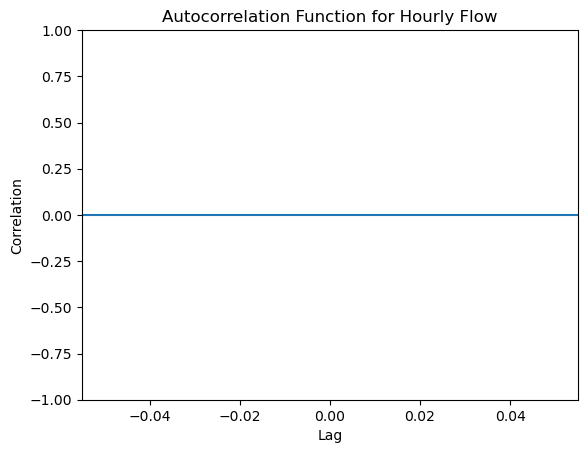

D:\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1200x500 with 0 Axes>

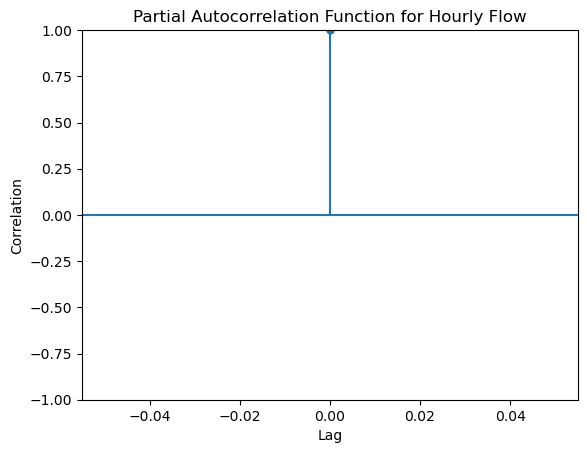

ValueError: This function does not handle missing values

In [50]:


# 选择分析的列
column_to_analyze = "Hourly Flow"
ts_data = df[column_to_analyze]
# 绘制 ACF
plt.figure(figsize=(12, 5))
plot_acf(ts_data)
plt.title(f"Autocorrelation Function for {column_to_analyze}")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

# 绘制 PACF
plt.figure(figsize=(12, 5))
plot_pacf(ts_data)
plt.title(f"Partial Autocorrelation Function for {column_to_analyze}")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

# 分解时间序列
decomposition = seasonal_decompose(ts_data, model='additive')

# 绘制趋势、季节性和残差分量
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
decomposition.trend.plot(ax=ax1)
ax1.set_title(f"{column_to_analyze} Trend")
decomposition.seasonal.plot(ax=ax2)
ax2.set_title(f"{column_to_analyze} Seasonality")
decomposition.resid.plot(ax=ax3)
ax3.set_title(f"{column_to_analyze} Residuals")
plt.tight_layout()
plt.show()








In [42]:
from statsmodels.tsa.arima_model import ARIMA

# 将数据集按时间升序排列
df = df.sort_index()

# 拆分训练集和测试集
train_data = df[(df.index >= '2022-01-01') & (df.index < '2022-10-01')]
test_data = df[(df.index >= '2022-10-01') & (df.index <= '2022-10-31')]


# 训练模型
model = SARIMAX(train_data[column_to_analyze], order=(2,1,2), seasonal_order=(1,1,1,24))
model_fit = model.fit(disp=0)






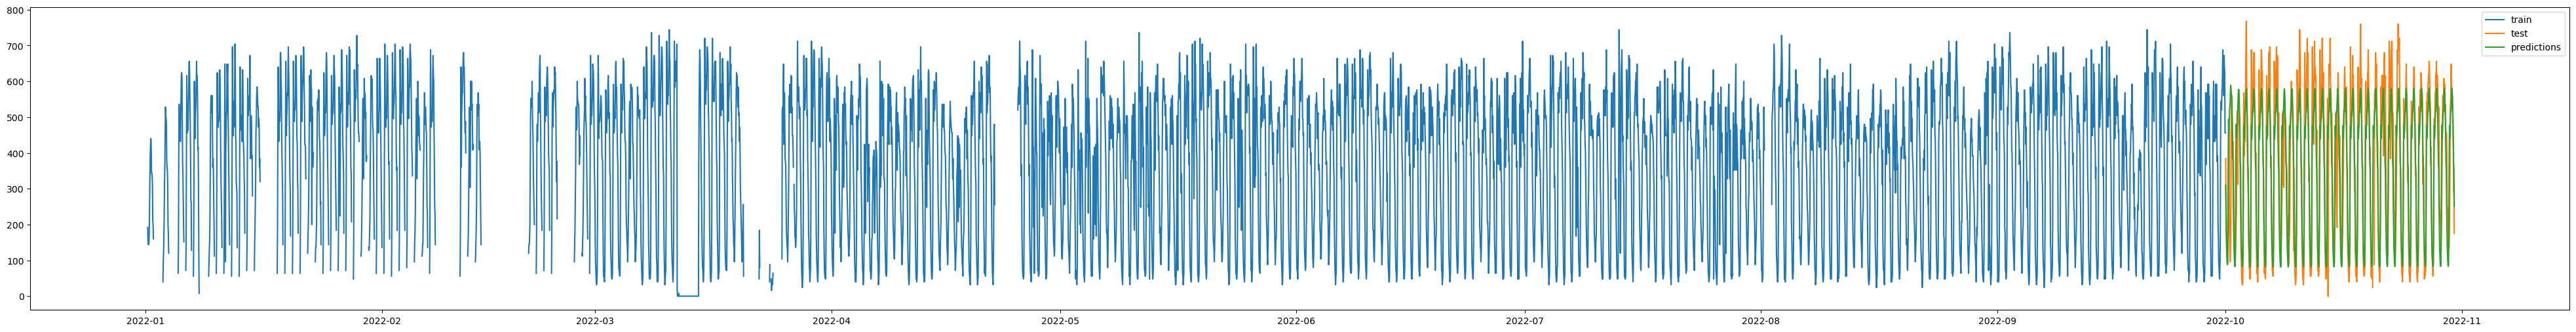

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 预测测试集
predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)

# 输出性能指标
#mse = mean_squared_error(test_data[column_to_analyze], predictions)
#rmse = np.sqrt(mse)
#mae = mean_absolute_error(test_data[column_to_analyze], predictions)
#print("Mean Squared Error (MSE): {:.3f}".format(mse))
#print("Root Mean Squared Error (RMSE): {:.3f}".format(rmse))
#print("Mean Absolute Error (MAE): {:.3f}".format(mae))

# 画出预测结果和真实值
plt.figure(figsize=(50, 6))
plt.plot(train_data.index, train_data[column_to_analyze], label='train')
plt.plot(test_data.index, test_data[column_to_analyze], label='test')
plt.plot(test_data.index, predictions, label='predictions')
plt.legend(loc='best')
plt.show()




In [52]:
pip install pystan


^C
Note: you may need to restart the kernel to use updated packages.


C:\Users\Cathy\AppData\Local\Temp\ipykernel_39776\1937686833.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['Week'] = df2['Date Time'].dt.week


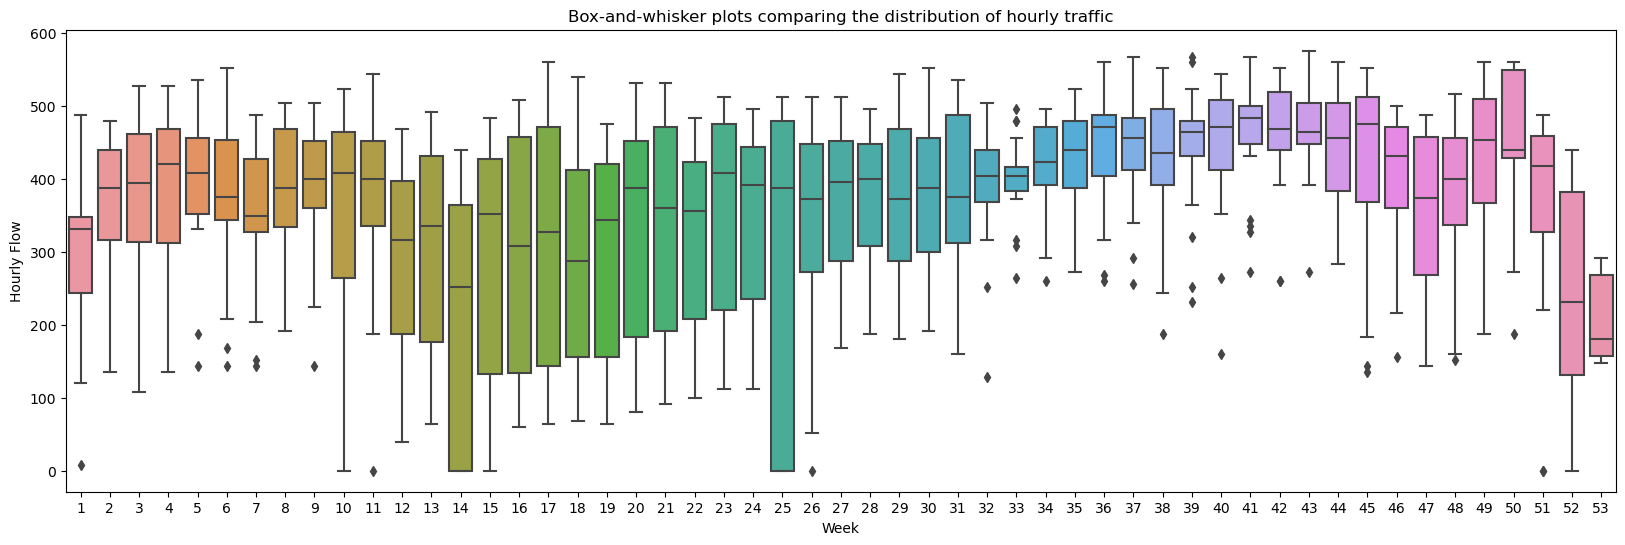

In [60]:
# 计算每日中位数

df2 = pd.read_excel("BOND ST EB L3 TRAFFIC.xlsx")


# 转换日期时间格式
df2['Date Time'] = pd.to_datetime(df2['Date Time'])
df2.sort_values('Date Time', inplace=True)

df2['Date'] = df2['Date Time'].dt.date
df2['Week'] = df2['Date Time'].dt.week
daily_median = df2.groupby(['Date','Week'])['Hourly Flow'].median().reset_index()

# 绘制箱线图
plt.figure(figsize=(20, 6))
sns.boxplot(x='Week', y='Hourly Flow', data=daily_median)
plt.title('Box-and-whisker plots comparing the distribution of hourly traffic')
plt.show()


In [63]:
from scipy.stats import ttest_ind
traffic_data=df2
window = 21
policy_data = pd.read_excel("Policy Time Frame.xlsx")
for index, row in policy_data.iterrows():
    policy_start_date = pd.to_datetime(row["Policy Start Date"])
    policy_end_date = pd.to_datetime(row["Policy End Date"])

    # 提取政策实施前后的交通流量数据
    pre_policy_data = traffic_data[(traffic_data["Date Time"] >= policy_start_date - pd.Timedelta(days=window)) & (traffic_data["Date Time"] < policy_start_date)]
    post_policy_data = traffic_data[(traffic_data["Date Time"] >= policy_start_date) & (traffic_data["Date Time"] < policy_start_date + pd.Timedelta(days=window))]

    # 计算政策实施前后的平均交通流量
    pre_policy_mean = pre_policy_data["Hourly Flow"].mean()
    post_policy_mean = post_policy_data["Hourly Flow"].mean()

    t_stat, p_value = ttest_ind(pre_policy_data["Hourly Flow"], post_policy_data["Hourly Flow"], equal_var=False)

# 输出结果
    print(f"Policy {index + 1}: {row['Policy Name']}")
    print(f"Pre-policy mean traffic flow: {pre_policy_mean:.2f}")
    print(f"Post-policy mean traffic flow: {post_policy_mean:.2f}")
    print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.5f}")

# 根据显著性水平（例如，0.05）判断政策实施前后交通流量变化是否显著
    alpha = 0.05
    if p_value < alpha:
        if post_policy_mean > pre_policy_mean:
            print("Policy has a significant positive impact on traffic flow.")
        else:
            print("Policy has a significant negative impact on traffic flow.")
    else:
        print("Policy has no significant impact on traffic flow.")

    print("\n")


Policy 1: Lockdown1
Pre-policy mean traffic flow: 363.02
Post-policy mean traffic flow: 206.98
T-statistic: 12.30, P-value: 0.00000
Policy has a significant negative impact on traffic flow.


Policy 2: Lockdown2
Pre-policy mean traffic flow: 346.21
Post-policy mean traffic flow: 289.80
T-statistic: 4.19, P-value: 0.00003
Policy has a significant negative impact on traffic flow.





Examining @/win-64::__archspec==1=x86_64:  80%|████████  | 4/5 [00:08<00:01,  1.84s/it]
                                                                                       

Examining conflict for python fbprophet:   0%|          | 0/5 [00:00<?, ?it/s]
                                                                              

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - fbprophet -> python[version='2.7.*|3.5.*|3.6.*|>=2.7,<2.8.0a0|>=3.5,<3.6.0a0|>=3.6,<3.7.0a0|>=3.8,<3.9.0a0|>=3.7,<3.8.0a0']

Your python: python=3.9

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you are constrained to. Note that conda will not
change your python version to a different minor version unless you explicitly specify
that.




Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed
